In [1]:
%matplotlib inline

In [4]:
cd ..

/home/luco/python/ml-imdb


# ParsedData 2 NumericData

In [7]:
import json

import numpy as np
import seaborn as sb

## Load Movies

In [8]:
with open("./lukasmap_1970_2000.json") as f:
    json_data = json.load(f)

In [9]:
movies = [
    (movie_name, movie_data)
    for movie_name, movie_data
    in json_data["data"].items()
    if "actors" in movie_data
]

In [10]:
len(movies)

62295

In [26]:
movies[0]

(u'The Intruders (1970)',
 {u'actors': {u'Graham, William A.'},
  u'btw': 0.0,
  u'rating': 5.9,
  u'votes': 106,
  u'year': 1970})

## Analysis of Actors

In [12]:
set_of_actors = set(
    actor
    for _, movie_data in movies
    for actor, _ in movie_data["actors"]
)

actor_freq = {actor: 0 for actor in set_of_actors}

for _, movie_data in movies:
    for actor, _ in movie_data["actors"]:
        actor_freq[actor] += 1

In [13]:
len(set_of_actors)

83311

## Actor Freq Histogram

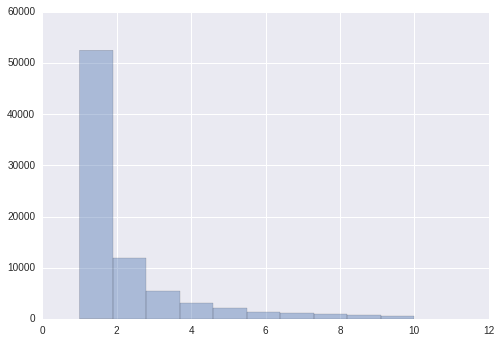

In [14]:
sb.distplot(
    [freq for _, freq in actor_freq.items()
     if freq < 11],
    kde=False, bins=10
)

The vast majority of actors occur just in a single movie.  That's called the data sparsity problem.

## Gettin' Rid of Data Sparsity

Let's filter out actors occuring infrequently:

In [15]:
actors = {actor for actor, freq in actor_freq.items() if freq >= 5}

In [16]:
len(actors)

10224

Now we need to filter out movies that do not contain any of the "restricted" actors.

In [17]:
for _, movie_data in movies:
    movie_data["actors"] = {
        actor for actor, __ in movie_data["actors"]
        if actor in actors
    }

movies = [
    (movie_name, movie_data)
    for movie_name, movie_data
    in movies if len(movie_data["actors"]) > 0
]

movies.sort(key=lambda (_, md): md["year"])

In [18]:
len(movies)

47149

## Release Year Histogram

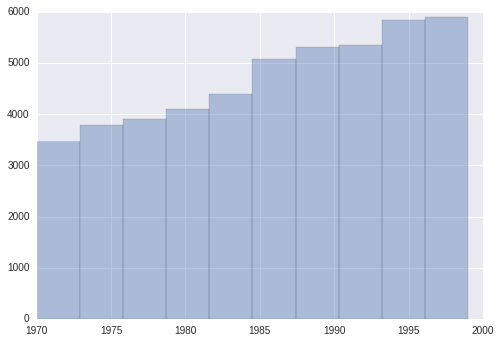

In [19]:
sb.distplot(
    [movie_data["year"] for _, movie_data in movies],
    kde=False, bins=10
)

## Baking Data

In [48]:
actor2i = {actor: i for i, actor in enumerate(sorted(actors))}

data_x = np.zeros(shape=(len(movies), len(actors)))
data_y = np.zeros(shape=(len(movies),1))

for movie_index, (movie_name, movie_data)  in enumerate(movies):
    for actor in movie_data["actors"]:
        data_x[movie_index, actor2i[actor]] = 1
    data_y[movie_index,0] = movie_data["rating"]

If we want to persist the data to disk for easier training in other notebooks:

In [88]:
np.save("x-only-actors.npy", data_x)
np.save("y-only-actors.npy", data_y)

(47149, 10224)

# Example Training

## Data for Training / Testing

We divide the data into 2 parts - movies are sorted chronologically, so we will test models 

In [49]:
threshold = 30000

x_train = data_x[:threshold,:]
x_test = data_x[threshold:,:]

y_train = data_y[:threshold]
y_test = data_y[threshold:]

In [52]:
x_train.shape, y_train.shape

((30000, 10224), (30000, 1))

## Rating Prediction with Simple Feedforward Neural Network

In [33]:
import keras as k

Using TensorFlow backend.


In [88]:
from keras.layers import Input, Dense, Dropout
from keras.activations import relu
from keras.models import Sequential

In [99]:
model = Sequential()

input_shape = (data_x.shape[1], )

model.add(Dense(128, activation=relu, input_shape=input_shape))
model.add(Dropout(0.33))
model.add(Dense(128, activation=relu))
model.add(Dropout(0.33))
model.add(Dense(1, activation=relu))

In [100]:
model.compile(loss="mse", metrics=["mae"], optimizer="adadelta")

In [101]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=10, batch_size=1000, verbose=1)

Train on 30000 samples, validate on 17149 samples
Epoch 1/10
30000/30000 [==============================] - 10s - loss: 30.0927 - mean_absolute_error: 5.1085 - val_loss: 2.0044 - val_mean_absolute_error: 1.1560
Epoch 2/10
30000/30000 [==============================] - 8s - loss: 2.1243 - mean_absolute_error: 1.1645 - val_loss: 1.6798 - val_mean_absolute_error: 1.0379
Epoch 3/10
30000/30000 [==============================] - 8s - loss: 1.8277 - mean_absolute_error: 1.0772 - val_loss: 1.6093 - val_mean_absolute_error: 1.0145
Epoch 4/10
30000/30000 [==============================] - 8s - loss: 1.6872 - mean_absolute_error: 1.0289 - val_loss: 1.5471 - val_mean_absolute_error: 0.9879
Epoch 5/10
30000/30000 [==============================] - 8s - loss: 1.5791 - mean_absolute_error: 0.9943 - val_loss: 1.5130 - val_mean_absolute_error: 0.9716
Epoch 6/10
30000/30000 [==============================] - 8s - loss: 1.5168 - mean_absolute_error: 0.9748 - val_loss: 1.4862 - val_mean_absolute_error: 0